# UN General Debates

First of all, import packages and data

In [2]:
import pandas as pd
import re
import nltk
import nltk.stem
from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer
from nltk.corpus import stopwords
from string import punctuation

#to plot inside the document
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
debates = pd.read_csv("un-general-debates.zip", compression='zip')

## Description

Have a first look at the data.

In [4]:
debates.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [5]:
debates.describe(include="all")

,session,year,country,text
count,7507.000000,7507.000000,7507,7507
unique,NaN,NaN,199,7507
top,NaN,NaN,NLD,"﻿Mr. President, your\nelection to preside over..."
freq,NaN,NaN,46,1
mean,49.610763,1994.610763,NaN,NaN
std,12.892155,12.892155,NaN,NaN
min,25.000000,1970.000000,NaN,NaN
25%,39.000000,1984.000000,NaN,NaN
50%,51.000000,1996.000000,NaN,NaN
75%,61.000000,2006.000000,NaN,NaN


We have 7507 speaches, ranging from 1970 to 2015.

They were spoken by representatives of 199 countries.

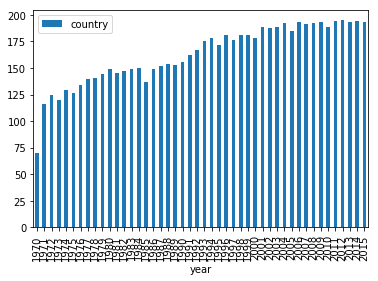

In [6]:
debates[["year", "country"]].groupby("year").count().plot(kind="bar")

It seems like more an more countries are speakers at the General Debates each year, from 1970 (70 countries) to at least 2006 (193 countries).

This is explained, at first by the end of series of decolonization in the 70s and 80s (more countries break of from their empires to become independent countries), then by the break-up of the Soviet Union after 1989.

## Text Preparation

Put all text to lower case to avoid problems. Certain characters are not recognized because of the encoding too.

In [7]:
debates['text'] = debates['text'].str.lower().map(lambda x: re.sub('\W+',' ', x))

Now let's transform the text to lists

In [8]:
debates['token'] = debates['text'].apply(word_tokenize)

We need to remove the punctuation and english stopwords to only keep the essence of the text.

In [9]:
stop_words = set(stopwords.words('english'))
# I noticed that "'s" is not included in stopwords, while I think it doesn't bring much meaning in a text, so I'll add it to the set to remove from the cleaned tokens.
stop_words.add("'s")
stop_words.add("'")
stop_words.add("-")
stop_words.add("'")
debates['clean'] = debates['token'].apply(lambda x: [w for w in x if not w in stop_words and not w in punctuation])

The last piece of preparation I want to do is now stemming (so we do not have different variations of same words separated).

In [10]:
stemmer = nltk.stem.PorterStemmer()

In [11]:
debates['stems'] = [[format(stemmer.stem(token)) for token in speech] for speech in debates['clean']]

In [12]:
debates.head()

,session,year,country,text,token,clean,stems
0,44,1989,MDV,it is indeed a pleasure for me and the member...,"[it, is, indeed, a, pleasure, for, me, and, th...","[indeed, pleasure, members, delegation, extend...","[inde, pleasur, member, deleg, extend, ambassa..."
1,44,1989,FIN,may i begin by congratulating you sir on your...,"[may, i, begin, by, congratulating, you, sir, ...","[may, begin, congratulating, sir, election, pr...","[may, begin, congratul, sir, elect, presid, ge..."
2,44,1989,NER,mr president it is a particular pleasure for ...,"[mr, president, it, is, a, particular, pleasur...","[mr, president, particular, pleasure, behalf, ...","[mr, presid, particular, pleasur, behalf, dele..."
3,44,1989,URY,during the debate at the fortieth session of ...,"[during, the, debate, at, the, fortieth, sessi...","[debate, fortieth, session, general, assembly,...","[debat, fortieth, session, gener, assembl, fou..."
4,44,1989,ZWE,i should like at the outset to express my del...,"[i, should, like, at, the, outset, to, express...","[like, outset, express, delegation, satisfacti...","[like, outset, express, deleg, satisfact, plea..."


It would be interesting to combine the speeches of all speakers of a session and plot the 25 most used words.

This will give us an idea of what the world was interested/worried about on each year.

In [13]:
all_per_year = debates.groupby('session').agg({'year': 'mean', 'clean': 'sum'})

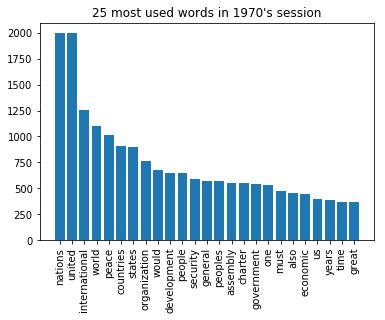

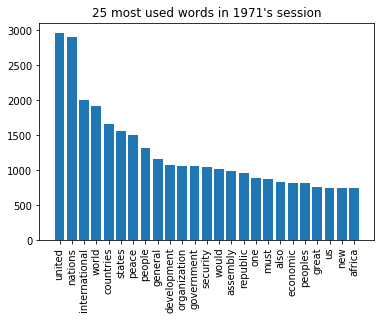

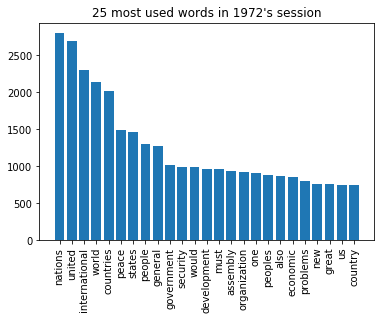

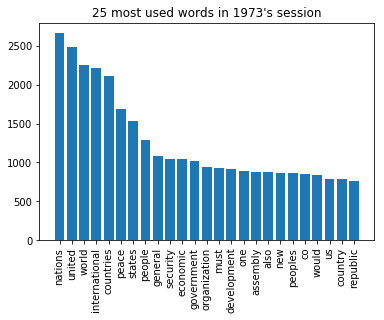

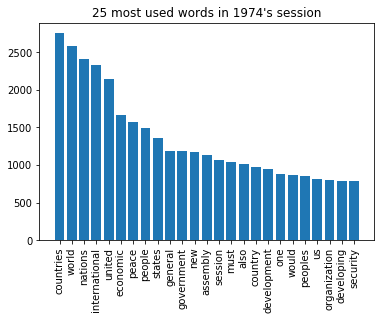

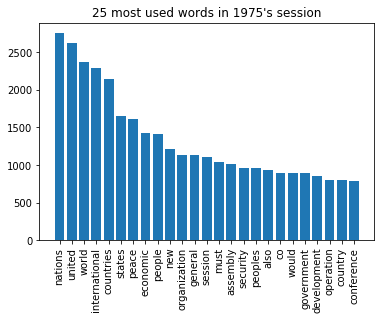

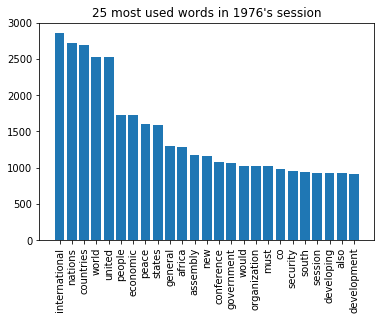

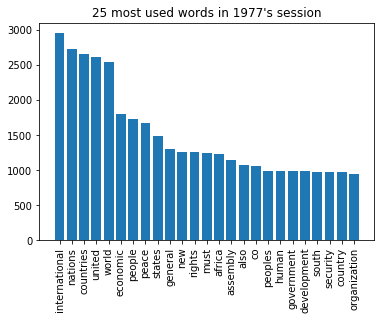

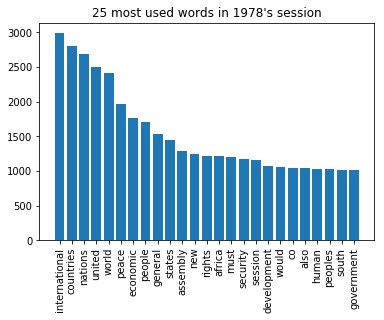

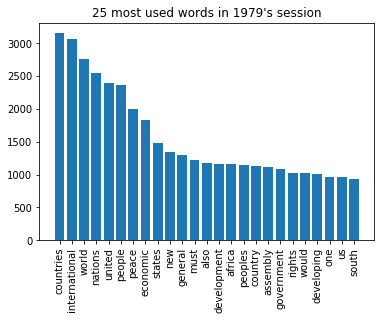

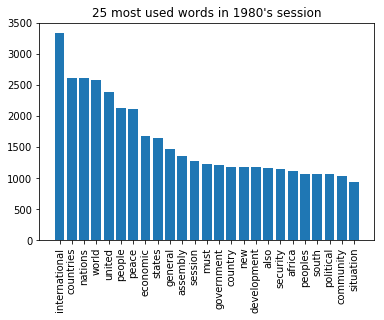

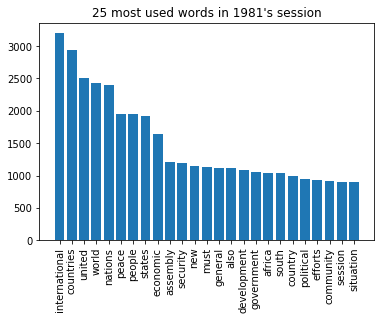

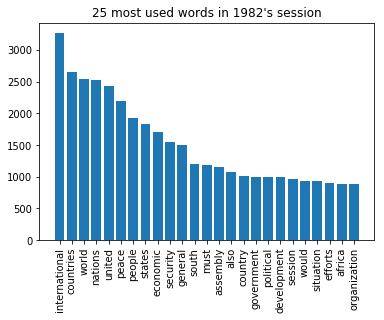

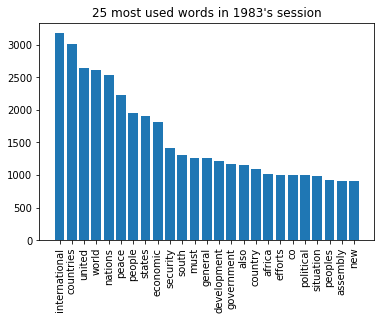

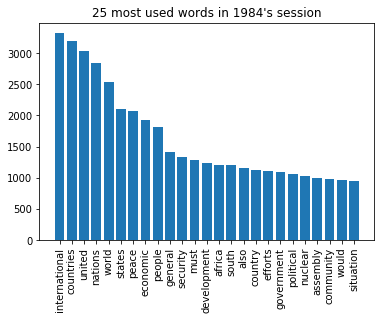

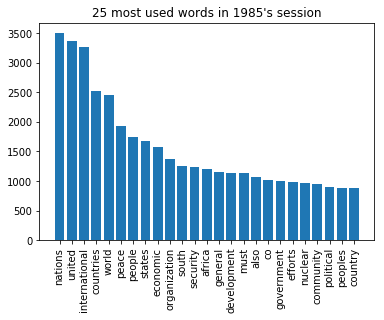

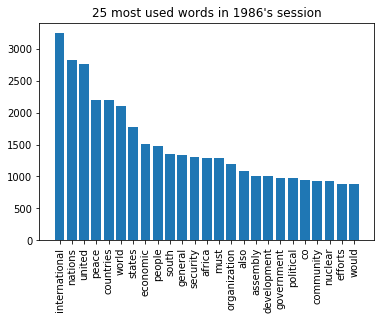

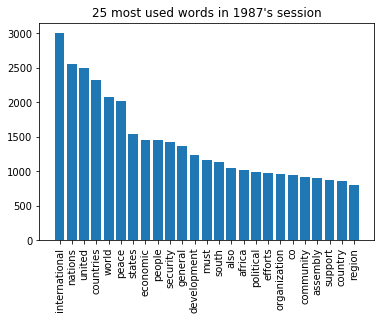

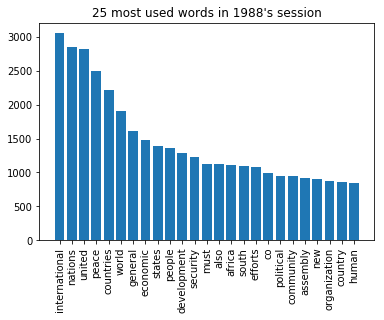

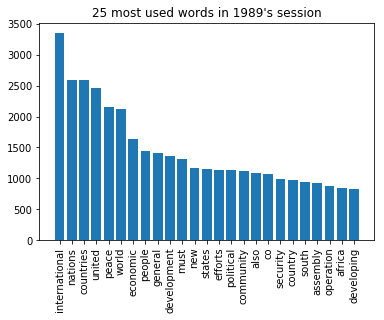

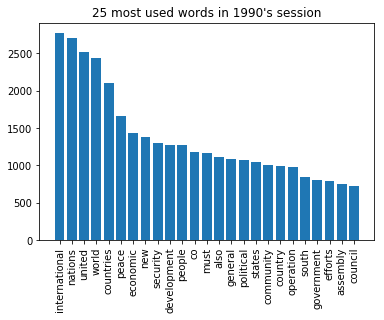

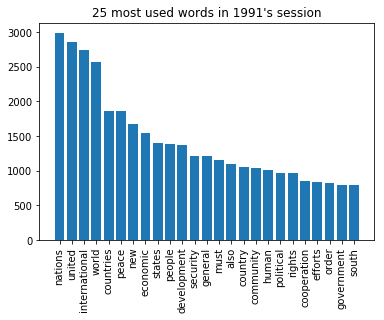

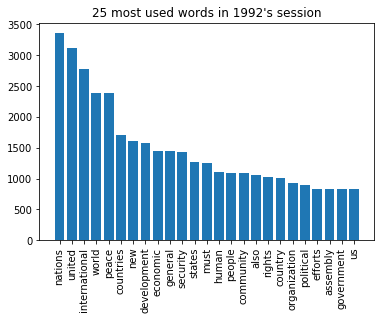

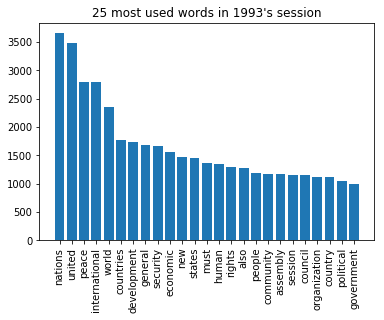

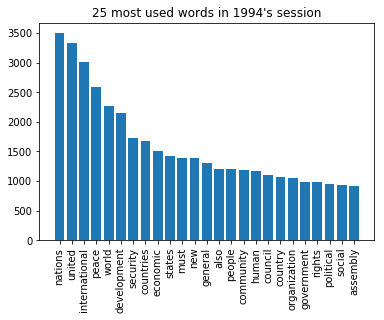

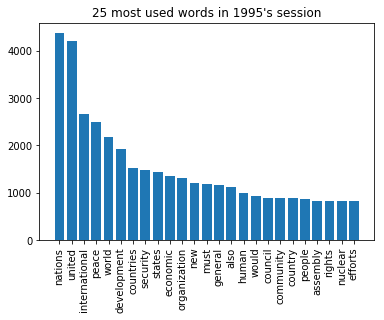

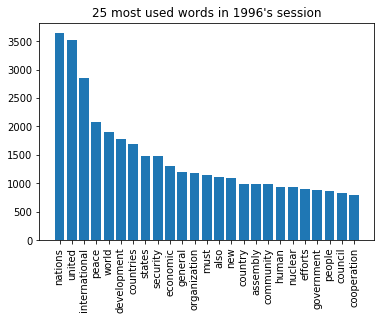

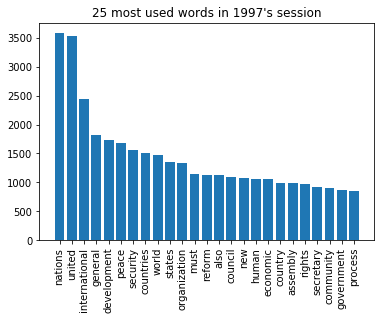

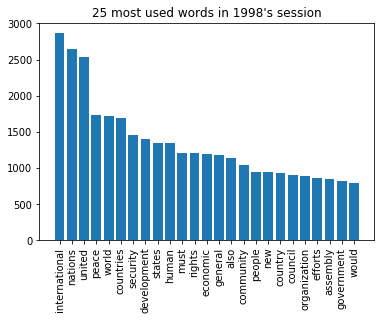

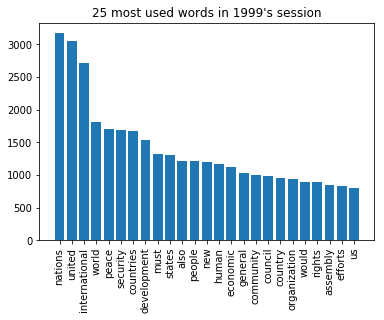

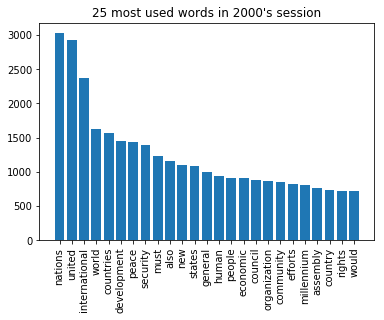

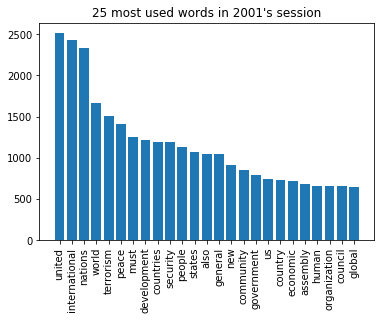

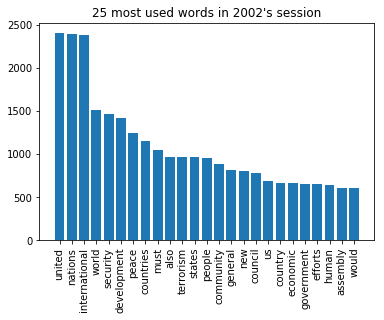

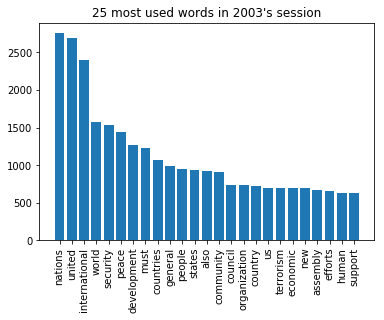

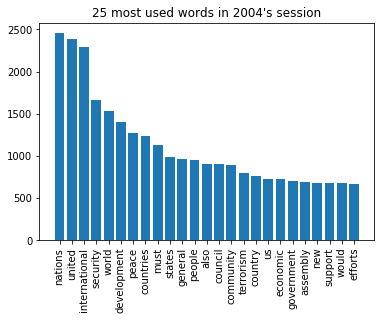

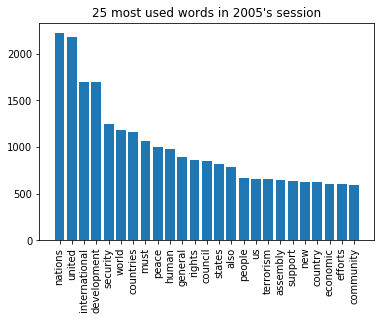

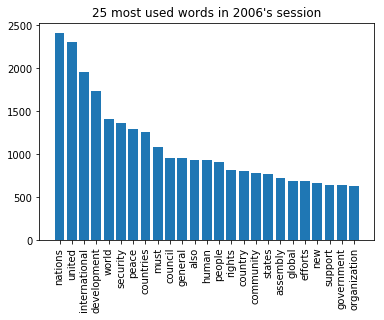

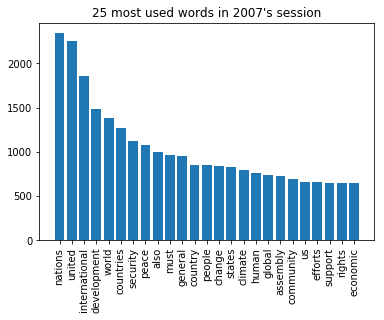

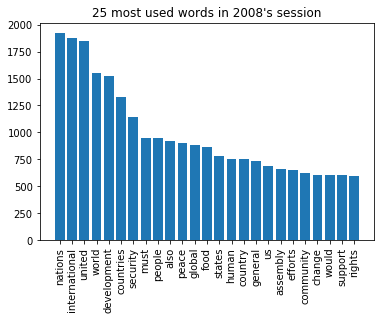

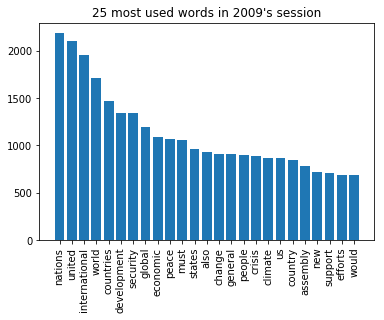

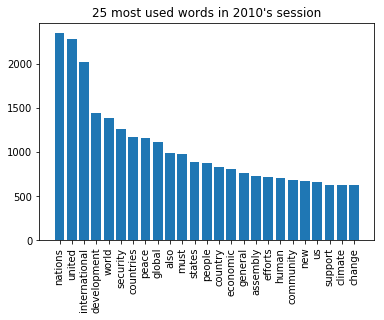

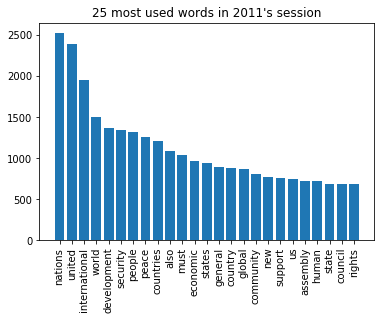

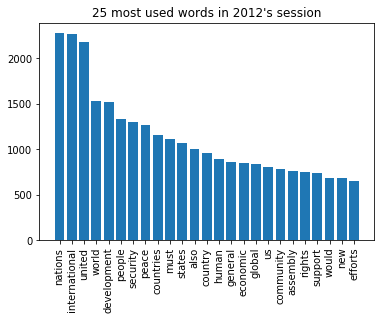

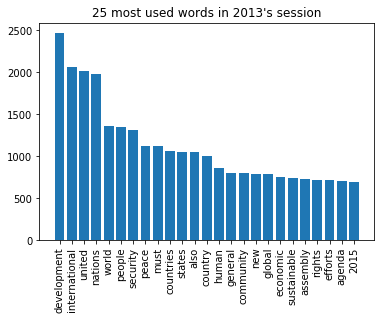

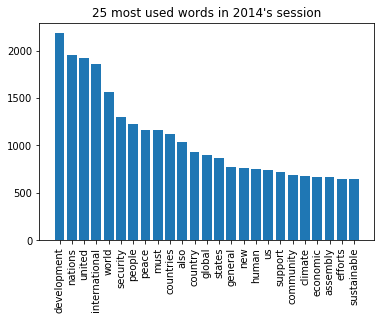

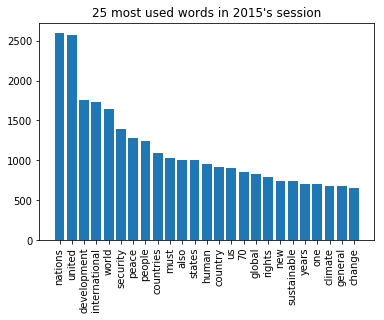

In [14]:
for i, row in all_per_year.iterrows():
    sess = dict(nltk.FreqDist(row['clean']))
    sort_sess = sorted(sess.items(), key=lambda x: x[1], reverse=True)[0:25]
    plt.bar(range(len(sort_sess)), [val[1] for val in sort_sess], align='center')
    plt.xticks(range(len(sort_sess)), [val[0] for val in sort_sess])
    plt.xticks(rotation=90)
    plt.title("25 most used words in %d's session" % row['year'])
    plt.show()

Interestingly, the constant most used words are "United" and "Nations". "General" and "Assembly" are both often part of the most cited. _**Are the UN General Assembly sessions a bit self-centered?...**_

2013 and 2014 are the only two years when words other than UN, countries or international made it in the top 3. This word is **"Development"**. Development has been gradually growing towards the first positions since the 1990s

The words "Peace" and "People" are always present in the top list.

Now, I'm just going to count and combine global and yearly occurrences of all words in all speeches.

In [15]:
freqs = {}
for i, speech in debates.iterrows():
    year = speech['year']
    for token in speech['stems']:
        if token not in freqs:
            freqs[token] = {"total_freq":1, year:1}
        else:
            freqs[token]["total_freq"] += 1
            if not freqs[token].get(year):
                freqs[token][year] = 1
            else:
                freqs[token][year] += 1

Now transform this dictionary of dictionaries into a dataframe

In [16]:
freqs_df = pd.DataFrame.from_dict(freqs, orient='index')
freqs_df['word'] = freqs_df.index

In [17]:
# Example of data for the stem of the word "peace"
freqs_df[freqs_df.index == "peac"]

,total_freq,1995,2015,1994,2006,1972,1984,1987,1988,1985,...,2013,2014,1971,1973,1974,1986,1996,2000,2001,word
peac,93962,2769.0,1539.0,2916.0,1503.0,1885.0,2636.0,2508.0,2968.0,2473.0,...,1433.0,1384.0,1799.0,2049.0,1907.0,2782.0,2334.0,1644.0,1578.0,peac


Make the dataframe a little more presentable (order columns chronologically, sort rows by total_freq).

In [18]:
new_cols = ["total_freq", "word"] + sorted(freqs_df.columns.tolist()[1:-1])
freqs_df = freqs_df[new_cols]

freqs_df = freqs_df.sort_values('total_freq', ascending=False)

freqs_df.head()

,total_freq,word,1970,1971,1972,1973,1974,1975,1976,1977,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
nation,156994,nation,2398.0,3474.0,3519.0,3451.0,3365.0,3544.0,3561.0,3511.0,...,2956.0,2959.0,2539.0,2764.0,2919.0,3191.0,2978.0,2699.0,2624.0,3195.0
countri,126889,countri,1256.0,2361.0,2756.0,2889.0,3728.0,2938.0,3553.0,3627.0,...,2057.0,2116.0,2083.0,2321.0,1992.0,2082.0,2115.0,2059.0,2047.0,2001.0
intern,124392,intern,1316.0,2132.0,2391.0,2362.0,2454.0,2427.0,3013.0,3118.0,...,2058.0,1964.0,1960.0,2065.0,2111.0,2083.0,2421.0,2195.0,1955.0,1826.0
unit,122559,unit,2011.0,2995.0,2728.0,2522.0,2196.0,2664.0,2548.0,2629.0,...,2330.0,2273.0,1878.0,2132.0,2307.0,2421.0,2218.0,2051.0,1968.0,2621.0
develop,109913,develop,1186.0,2015.0,2054.0,1960.0,2369.0,1885.0,2397.0,2487.0,...,2520.0,2231.0,2319.0,2238.0,2133.0,2032.0,2110.0,3127.0,2758.0,2249.0


In [19]:
freqs_df.shape

(34248, 48)

In [20]:
freqs_df.tail(30)

,total_freq,word,1970,1971,1972,1973,1974,1975,1976,1977,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
jioj,1,jioj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jinha,1,jinha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jingoist,1,jingoist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jingoism,1,jingoism,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
jima,1,jima,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jocasta,1,jocasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jim,1,jim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jill,1,jill,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jilani,1,jilani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jil,1,jil,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We're working with 35,026 stems (an improvement from 84,256 unique words befor using the stemming method). Though looking at the less used words makes me realize that much more cleaning would be appropriate to get rid of some concatenated words or even strange characters...

## Word trends

Let's plot the most used, to see their evolution over time.

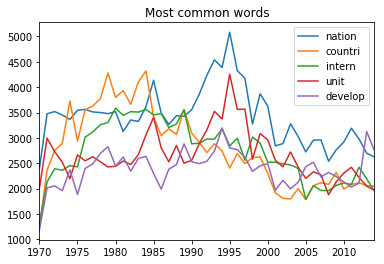

In [21]:
freqs_df.iloc[0:5, 1:47].transpose().iloc[1:].plot(title="Most common words")

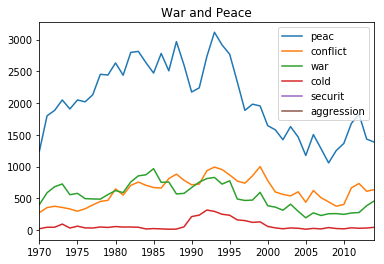

In [22]:
freqs_df[freqs_df['word'].isin(['peac', 'war', 'securit', 'cold', 'conflict', 'aggression'])].iloc[:, 1:47].transpose().iloc[1:].plot(title = "War and Peace")

Peace and Security are main concerns of the United Nations throughout the years.

It's very interesting to see the use of the word peace decline so drastically around the fall of the Berlin Wall (concurrently to a peak in the use of "aggression", for some reason I cannot explain), then kick back to the same level right afterward... Since the mid 90s, I am deeply sorry to see it decrease so much...

I do not see any particular trend over the words war or conflict. I do, though, see a surge on the use of "cold" at the end of the 80s, gradually descending after this. I would think that this has to do with the Cold War, which was ending at the time.

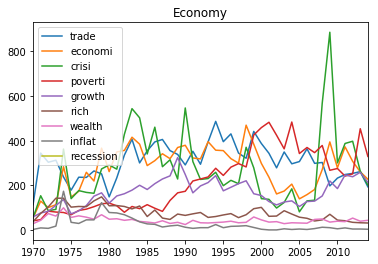

In [23]:
freqs_df[freqs_df['word'].isin(['economi', 'wealth', 'crisi', 'growth', 'inflat', 'trade', 'poverti', 'rich', 'recession', 'income'])].iloc[:, 1:47].transpose().iloc[1:].plot(title="Economy")

Here, we see the spikes of the 73 and 75 Oil Crises, the 1980s and the 1990 recession, what I believe to be the 1998 Ruble Crisis, and the 2008 crisis.

Poverty has changed in level of prevalence between 1985 and 2000, increasing drastically.

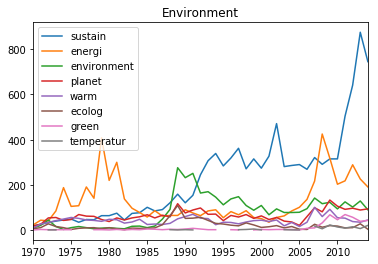

In [24]:
freqs_df[freqs_df['word'].isin(['environment', 'sustain', 'green', 'energi', 'ecolog', 'warm', 'temperatur', 'pollution', 'planet'])].iloc[:, 1:47].transpose().iloc[1:].plot(title="Environment")

Interesting trends here:

- Energy was mentionned a lot in the 70s and 80s because of the Oil Crises, and reappeared in the 2000s in the context of the environmentalism for different reasons.

- There was an interest for the environment (and pollution) in the 70s, which fell into oblivion (probably because the world was struggling with energy issues at the time) until the end 80s. This huge spike then slowly degraded.

- Sustainability is a notion that appeared in the 90s, and has since been growing especially since the 2010s.

In general, the later years show an increase in worries over environmental issues.

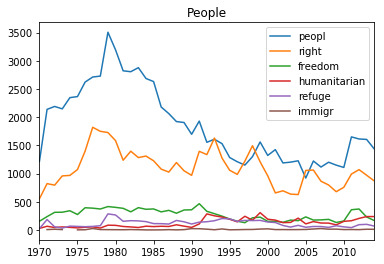

In [25]:
freqs_df[freqs_df['word'].isin(['peopl', 'inequaliti', 'refuge', 'humanitarian', 'immigr', 'freedom', 'right'])].iloc[:, 1:47].transpose().iloc[1:].plot(title="People")

Peoples are always a subject of interest in UN debates. The concern over Freedom, however, has declined after the fall of the Eastern Block (though it reappeared  in the early 2010s, I can't seem to recall the context).

Humanitarian aid seems to have exploded in the 90s with famines in Somalia, North Korea, Sudan, Ethiopia.

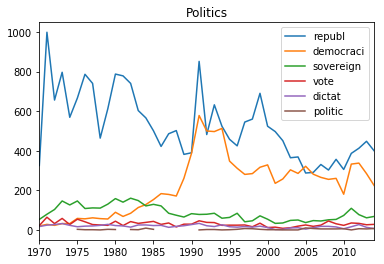

In [26]:
freqs_df[freqs_df['word'].isin(['democraci', 'republ', 'dictat', 'sovereign', 'politic', 'vote'])].iloc[:, 1:47].transpose().iloc[1:].plot(title="Politics")

The end of decolonization was a period when Sovereignty was an important concept. It is still a concern since, during the UN General Assembly, in a more relative measure.

The end of the Cold War brought a spike in the use of the word Democracy, which is now a constantly used word in debates. It's interesting to see how much less that word was brandished before that period...

Republic comes very often with great variations. I believe it must be because so many countries are called "Republic of ...", and speakers use the complete names of countries when refering to one another.

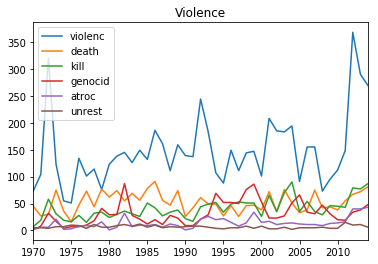

In [27]:
freqs_df[freqs_df['word'].isin(['violenc', 'unrest', 'genocid', 'atroc', 'kill', 'death'])].iloc[:, 1:47].transpose().iloc[1:].plot(title="Violence")

I had to remove the word Terrorism out of the plot (see below), because the difference of scale made the other words unnoticeable...

Both the 70s and early 2000s had their violent terrrorism episodes. The word Violence, unhappily, rarely decreases in use...

Here we can notice the genocides of Cambodia (1975-79), Guatemala (1981), Bosnia-Herzegovine (1992), Rwanda (1994), Sudan (2003).

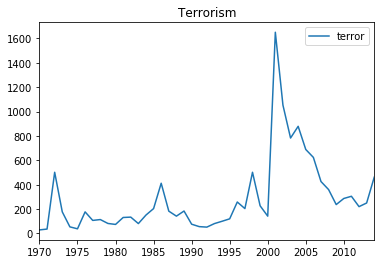

In [28]:
freqs_df[freqs_df['word'].isin(['terror'])].iloc[:, 1:47].transpose().iloc[1:].plot(title="Terrorism")

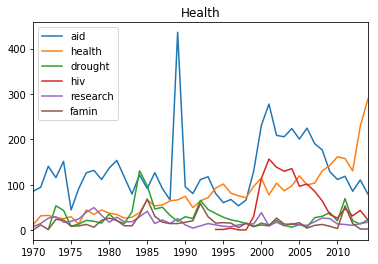

In [29]:
freqs_df[freqs_df['word'].isin(['health', 'disease', 'famin', 'drought', 'hiv', 'aid', 'research'])].iloc[:, 1:47].transpose().iloc[1:].plot(title="Health")

Health is definitively a growing concern. Unhappily, research is not.

HIV started being mentioned in the UN roughly 10 years after AIDS (though I believe this has to be taken with a grain of salt as word is probably mistaken for some sor of aids, helps).

Cases of droughts always entails famine episodes.

## Countries mentioned

I want to find out which countries speakers mention, and will show trends in time, as well as  look at whether certain countries speak more about specific other countries. List found [here](http://www.nationsonline.org/oneworld/country_code_list.htm), and tweaked here and there for better results.

In [30]:
#IPython.load_extensions('usability/hide_input/main');
countries = dict((k, v.lower()) for k,v in {
    'AFG': 'Afghanistan', 
    'ALA': 'Aland Islands', 
    'ALB': 'Albania', 
    'DZA': 'Algeria', 
    'ASM': 'American Samoa', 
    'AND': 'Andorra', 
    'AGO': 'Angola', 
    'AIA': 'Anguilla', 
    'ATA': 'Antarctica', 
    'ATG': 'Antigua and Barbuda', 
    'ARG': 'Argentina', 
    'ARM': 'Armenia', 
    'ABW': 'Aruba', 
    'AUS': 'Australia', 
    'AUT': 'Austria', 
    'AZE': 'Azerbaijan', 
    'BHS': 'Bahamas', 
    'BHR': 'Bahrain', 
    'BGD': 'Bangladesh', 
    'BRB': 'Barbados', 
    'BLR': 'Belarus', 
    'BEL': 'Belgium', 
    'BLZ': 'Belize', 
    'BEN': 'Benin', 
    'BMU': 'Bermuda', 
    'BTN': 'Bhutan', 
    'BOL': 'Bolivia', 
    'BIH': 'Bosnia and Herzegovina', 
    'BWA': 'Botswana', 
    'BVT': 'Bouvet Island', 
    'BRA': 'Brazil', 
    'VGB': 'Virgin Islands', 
    'IOT': 'British Indian Ocean Territory', 
    'BRN': 'Brunei', 
    'BGR': 'Bulgaria', 
    'BFA': 'Burkina Faso', 
    'BDI': 'Burundi', 
    'KHM': 'Cambodia', 
    'CMR': 'Cameroon', 
    'CAN': 'Canada', 
    'CPV': 'Cape Verde', 
    'CYM': 'Cayman Islands', 
    'CAF': 'Central Africa', 
    'TCD': 'Chad', 
    'CHL': 'Chile', 
    'CHN': 'China', 
    'HKG': 'Hong Kong', 
    'MAC': 'Macao', 
    'CXR': 'Christmas Island', 
    'CCK': 'Cocos Islands', 
    'COL': 'Colombia', 
    'COM': 'Comoros', 
    'COG': 'Congo', 
    'COD': 'Democratic Republic of Congo', 
    'COK': 'Cook Islands', 
    'CRI': 'Costa Rica', 
    'CIV': "Cote d'Ivoire", 
    'HRV': 'Croatia', 
    'CUB': 'Cuba', 
    'CYP': 'Cyprus', 
    'CZE': 'Czech Republic', 
    'DNK': 'Denmark', 
    'DJI': 'Djibouti', 
    'DMA': 'Dominica', 
    'DOM': 'Dominican Republic', 
    'ECU': 'Ecuador', 
    'EGY': 'Egypt', 
    'SLV': 'El Salvador', 
    'GNQ': 'Equatorial Guinea', 
    'ERI': 'Eritrea', 
    'EST': 'Estonia', 
    'ETH': 'Ethiopia', 
    'FLK': 'Falkland', 
    'FRO': 'Faroe', 
    'FJI': 'Fiji', 
    'FIN': 'Finland', 
    'FRA': 'France', 
    'GUF': 'French Guiana', 
    'PYF': 'French Polynesia', 
    'ATF': 'French Southern Territories', 
    'GAB': 'Gabon', 
    'GMB': 'Gambia', 
    'GEO': 'Georgia', 
    'DEU': 'Germany', 
    'GHA': 'Ghana', 
    'GIB': 'Gibraltar', 
    'GRC': 'Greece', 
    'GRL': 'Greenland', 
    'GRD': 'Grenada', 
    'GLP': 'Guadeloupe', 
    'GUM': 'Guam', 
    'GTM': 'Guatemala', 
    'GGY': 'Guernsey', 
    'GIN': 'Guinea', 
    'GNB': 'Guinea-Bissau', 
    'GUY': 'Guyana', 
    'HTI': 'Haiti', 
    'HMD': 'Heard and Mcdonald Islands', 
    'VAT': 'Vatican', 
    'HND': 'Honduras', 
    'HUN': 'Hungary', 
    'ISL': 'Iceland', 
    'IND': 'India', 
    'IDN': 'Indonesia', 
    'IRN': 'Iran', 
    'IRQ': 'Iraq', 
    'IRL': 'Ireland', 
    'IMN': 'Isle of Man', 
    'ISR': 'Israel', 
    'ITA': 'Italy', 
    'JAM': 'Jamaica', 
    'JPN': 'Japan', 
    'JEY': 'Jersey', 
    'JOR': 'Jordan', 
    'KAZ': 'Kazakhstan', 
    'KEN': 'Kenya', 
    'KIR': 'Kiribati', 
    'PRK': 'North Korea', 
    'KOR': 'South Korea', 
    'KWT': 'Kuwait', 
    'KGZ': 'Kyrgyzstan', 
    'LAO': 'Lao', 
    'LVA': 'Latvia', 
    'LBN': 'Lebanon', 
    'LSO': 'Lesotho', 
    'LBR': 'Liberia', 
    'LBY': 'Libya', 
    'LIE': 'Liechtenstein', 
    'LTU': 'Lithuania', 
    'LUX': 'Luxembourg', 
    'MKD': 'Macedonia', 
    'MDG': 'Madagascar', 
    'MWI': 'Malawi', 
    'MYS': 'Malaysia', 
    'MDV': 'Maldives', 
    'MLI': 'Mali', 
    'MLT': 'Malta', 
    'MHL': 'Marshall Islands', 
    'MTQ': 'Martinique', 
    'MRT': 'Mauritania', 
    'MUS': 'Mauritius', 
    'MYT': 'Mayotte', 
    'MEX': 'Mexico', 
    'FSM': 'Micronesia', 
    'MDA': 'Moldova', 
    'MCO': 'Monaco', 
    'MNG': 'Mongolia', 
    'MNE': 'Montenegro', 
    'MSR': 'Montserrat', 
    'MAR': 'Morocco', 
    'MOZ': 'Mozambique', 
    'MMR': 'Myanmar', 
    'NAM': 'Namibia', 
    'NRU': 'Nauru', 
    'NPL': 'Nepal', 
    'NLD': 'Netherlands', 
    'ANT': 'Netherlands Antilles', 
    'NCL': 'New Caledonia', 
    'NZL': 'New Zealand', 
    'NIC': 'Nicaragua', 
    'NER': 'Niger', 
    'NGA': 'Nigeria', 
    'NIU': 'Niue', 
    'NFK': 'Norfolk Island', 
    'MNP': 'Northern Mariana Islands', 
    'NOR': 'Norway', 
    'OMN': 'Oman', 
    'PAK': 'Pakistan', 
    'PLW': 'Palau', 
    'PSE': 'Palestine', 
    'PAN': 'Panama', 
    'PNG': 'Papua New Guinea', 
    'PRY': 'Paraguay', 
    'PER': 'Peru', 
    'PHL': 'Philippines', 
    'PCN': 'Pitcairn', 
    'POL': 'Poland', 
    'PRT': 'Portugal', 
    'PRI': 'Puerto Rico', 
    'QAT': 'Qatar', 
    'REU': 'Reunion', 
    'ROU': 'Romania', 
    'RUS': 'Russia', 
    'RWA': 'Rwanda', 
    'BLM': 'Saint-Barthelemy', 
    'SHN': 'Saint Helena', 
    'KNA': 'Saint Kitts', 
    'LCA': 'Saint Lucia', 
    'MAF': 'Saint-Martin', 
    'SPM': 'Saint Pierre and Miquelon', 
    'VCT': 'Saint Vincent and Grenadines', 
    'WSM': 'Samoa', 
    'SMR': 'San Marino', 
    'STP': 'Sao Tome and Principe', 
    'SAU': 'Saudi Arabia', 
    'SEN': 'Senegal', 
    'SRB': 'Serbia', 
    'SYC': 'Seychelles', 
    'SLE': 'Sierra Leone', 
    'SGP': 'Singapore', 
    'SVK': 'Slovakia', 
    'SVN': 'Slovenia', 
    'SLB': 'Solomon Islands', 
    'SOM': 'Somalia', 
    'ZAF': 'South Africa', 
    'SGS': 'South Georgia and the South Sandwich Islands', 
    'SSD': 'South Sudan', 
    'ESP': 'Spain', 
    'LKA': 'Sri Lanka', 
    'SDN': 'Sudan', 
    'SUR': 'Suriname', 
    'SJM': 'Svalbard', 
    'SWZ': 'Swaziland', 
    'SWE': 'Sweden', 
    'CHE': 'Switzerland', 
    'SYR': 'Syria', 
    'TWN': 'Taiwan', 
    'TJK': 'Tajikistan', 
    'TZA': 'Tanzania', 
    'THA': 'Thailand', 
    'TLS': 'Timor', 
    'TGO': 'Togo', 
    'TKL': 'Tokelau', 
    'TON': 'Tonga', 
    'TTO': 'Trinidad', 
    'TUN': 'Tunisia', 
    'TUR': 'Turkey', 
    'TKM': 'Turkmenistan', 
    'TCA': 'Turks and Caicos Islands', 
    'TUV': 'Tuvalu', 
    'UGA': 'Uganda', 
    'UKR': 'Ukraine', 
    'ARE': 'United Arab Emirates', 
    'GBR': 'United Kingdom', 
    'USA': 'United States', 
    'UMI': 'US Minor Outlying Islands', 
    'URY': 'Uruguay', 
    'UZB': 'Uzbekistan', 
    'VUT': 'Vanuatu', 
    'VEN': 'Venezuela', 
    'VNM': 'Viet Nam', 
    'VIR': 'Virgin Islands', 
    'WLF': 'Wallis and Futuna', 
    'ESH': 'Western Sahara', 
    'YEM': 'Yemen', 
    'ZMB': 'Zambia', 
    'ZWE': 'Zimbabwe'
}.items())

In [31]:
debates['countries_mentioned'] = debates['token'].apply(lambda token: {x:token.count(x) for x in token if x in countries.values()})

I'll now save this in a table for study and display

In [32]:
country_mentions = pd.concat([debates[["year", "country"]],
                              debates['countries_mentioned'].apply(pd.Series)], axis=1).dropna(axis=1, how='all')
country_mentions['country'] = country_mentions['country'].apply(lambda x: countries.get(x))
country_mentions.head()

,year,country,afghanistan,albania,algeria,andorra,angola,anguilla,antarctica,argentina,...,uganda,ukraine,uruguay,uzbekistan,vanuatu,vatican,venezuela,yemen,zambia,zimbabwe
0,1989,maldives,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1989,finland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989,niger,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,1989,uruguay,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1989,zimbabwe,2.0,NaN,NaN,NaN,3.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


This table is a little too long and large to make sense out of it. Let's group it by country to get the speaking country info.

In [33]:
country_mentions_by_country = country_mentions.groupby("country")[country_mentions.columns[2:]].sum()

Trying to plot a sankey diagram of countries mentioning each other.

In [42]:
# First need to melt country_mentions_by_country to long form
sankey_data = country_mentions_by_country.unstack().reset_index()
sankey_data = sankey_data.sort_values(by=0, ascending=False)[0:200]
sankey_data.head()

,level_0,country,0
15603,japan,japan,1653.0
14628,iraq,iraq,1583.0
17552,lebanon,lebanon,1468.0
15018,israel,israel,1412.0
0,afghanistan,afghanistan,1398.0


In [43]:
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode()

data = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    valuesuffix = "TWh"   
  )

layout =  dict(
    title = "Which countries mention which in the UN's General Assembly\n(1970-2015)",
    font = dict(
      size = 10
    )
)

data_trace = dict(
    type='sankey',
    width = 1118,
    height = 772,
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    valuesuffix = "TWh",
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  sankey_data['country']
  ),
    link = dict(
      source =  sankey_data['level_0'],
      target =  sankey_data['country'],
      value =  sankey_data[0],
      label =  sankey_data['level_0']
  ))

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [36]:
from ipysankeywidget import SankeyWidget

In [37]:
sankey_data.columns = ['source','target','value']
sankey_data = sankey_data.sort_values(by='value', ascending=False)
sankey_data.head()

,source,target,value
15603,japan,japan,1653.0
14628,iraq,iraq,1583.0
17552,lebanon,lebanon,1468.0
15018,israel,israel,1412.0
0,afghanistan,afghanistan,1398.0


In [38]:
links=sankey_data[0:200].dropna()[['source','target','value']].to_dict(orient='records')
links[:3]

[{'source': 'japan', 'target': 'japan', 'value': 1653.0},
 {'source': 'iraq', 'target': 'iraq', 'value': 1583.0},
 {'source': 'lebanon', 'target': 'lebanon', 'value': 1468.0}]

In [39]:
SankeyWidget(value={'links': links},
             width=800, height=800,margins=dict(top=0, bottom=0))

A Jupyter Widget